In [1]:
import sys
sys.path.append('../')
from analysis import analysis
from helper_functions import get_mids_from_edges, get_T_in_log10_Kelvin
sys.path.append('../../')
from custom_tools import plot_one_pulse

import matplotlib.pyplot as plt
import numpy as np

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
Rank reporting: 0


In [2]:
ST = analysis('local', 'test', 'model')
channel_mids = get_mids_from_edges(ST.instrument.channel_edges)

machine variable is not in environment variables, using passed argument.
machine: local
run_type is not in environment variables, using passed argument.
run_type: test
cannot import analysis name, using test_analysis
analysis_name: test_analysis
num_energies from environment variables failed, proceeding with default.
num_energies: 40
num_leaves from environment variables failed, proceeding with default.
num_leaves: 30
sqrt_num_cells from environment variables failed, proceeding with default.
sqrt_num_cells: 50
live_points from environment variables failed, proceeding with default.
live_points: 20
max_iter from environment variables failed, proceeding with default.
max_iter: 10
bkg environment variable is not allowed to be None, using passed argument: model.
bkg: model
support_factor: None
Creating parameter:
    > Named "column_density" with bounds [0.000e+00, 1.000e+01].
    > Units of 10^21 cm^-2.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin freq

In [3]:
T_else = 0.5 #keV

p = [1.4, # mass
      11, # radius
      3.5, #distance
      np.cos(58*np.pi/180), #inclination
      0.2, # phase shift
      np.cos(11*np.pi/180), # hot spot colatitude
      np.cos(10*np.pi/180), #hot spot size 10/46
      0.85/511, # Tseed
      50*1000/511, # T electrons # 50
      1., # tau
      get_T_in_log10_Kelvin(T_else)] #T_elsewhere

if ST.bkg == 'model':
    diskbb_T_keV = 0.29 #keV

    diskbb_T_log10_K = get_T_in_log10_Kelvin(diskbb_T_keV)
    p.append(diskbb_T_log10_K)

    R_in = 55 # km
    p.append(R_in)
    
p.append(1.13)

In [4]:
ST.likelihood(p, reinitialise=True)

120012223.11563364

(<Figure size 500x300 with 2 Axes>,
 <AxesSubplot: xlabel='Phase', ylabel='Energy (keV)'>)

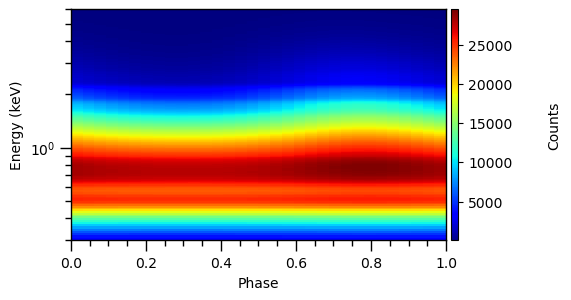

In [5]:
plot_one_pulse(ST.signal.expected_counts, ST.phases_space, ST.instrument.channel_edges)

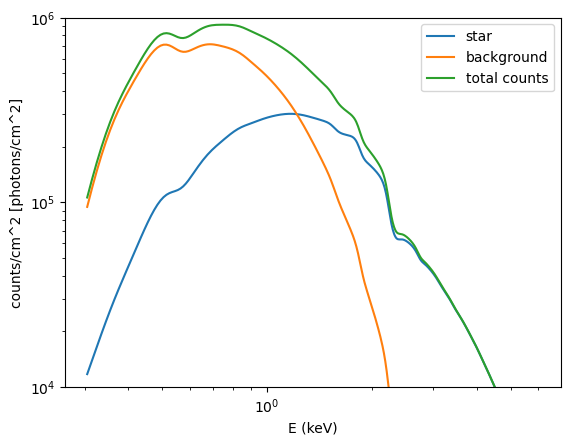

In [6]:
#compare star against background! this includes interstellar

fig, ax = plt.subplots()

ax.loglog(channel_mids, np.sum(ST.signal.signal_from_star,axis=1), label='star')
ax.loglog(channel_mids, np.sum(ST.background.registered_background*ST.data.exposure_time, axis=1), label='background')
ax.loglog(channel_mids, np.sum(ST.signal.expected_counts, axis=1), label='total counts')
ax.set_ylabel('counts/cm^2 [photons/cm^2]')
ax.set_xlabel('E (keV)')
ax.set_ylim([1e4, 1e6])
ax.legend()

Text(0, 0.5, 'F (KeV/s/cm^2)')

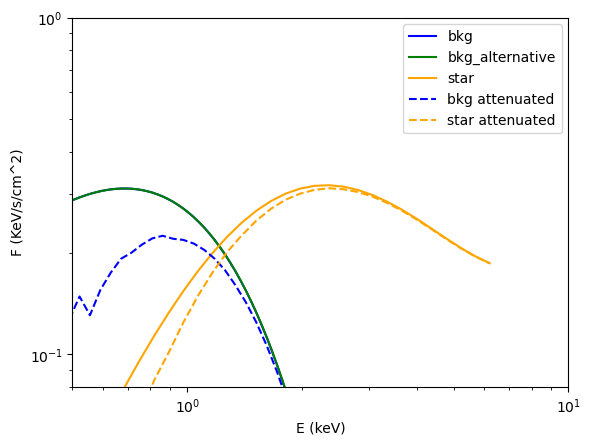

In [7]:
E = np.logspace(np.log10(0.01), np.log10(5.0), 100)
compensate_bins = (np.asarray([E[i+1]-E[i] for i in range(len(E)-1)])/get_mids_from_edges(E))
spectral_radiance = ST.background.B_E 
f_disk = ST.background.get_f_disk(E, spectral_radiance) #keV/cm^2/s/KeV
F_disk = E*f_disk  # keV/cm^2/s
F_disk_alternative = ST.background.get_F_disk(E, spectral_radiance)/compensate_bins #keV/cm^2/s
star_flux = np.sum(ST.photosphere.signal[0][0]/(ST.star['distance']*3.086e19)**2, axis=1)/ST.signal.phases[0].shape[0] # 3.086e19 to convert kpc to m # photons/cm^2/s/KeV
star_flux = ST.signal.energies**2*star_flux # keV/cm^2/s

fig, ax = plt.subplots()

ax.loglog(E, F_disk, label='bkg', color='blue') #keV/cm^2/s
ax.loglog(get_mids_from_edges(E), F_disk_alternative, label='bkg_alternative', color='green') #keV/cm^2/s
ax.loglog(ST.signal.energies, star_flux, label='star', color='orange') #keV/cm^2/s
ax.set_ylim([8e-2, 1e0])
ax.set_xlim([5e-1, 1e1])


# apply interstellar attenuation
ST.interstellar(E, F_disk)
ST.interstellar(ST.signal.energies, star_flux)

ax.loglog(E, F_disk, '--', label='bkg attenuated', color='blue') #keV/cm^2/s
ax.loglog(ST.signal.energies, star_flux, '--',label='star attenuated', color='orange') #keV/cm^2/s

ax.legend()
ax.set_xlabel('E (keV)')
ax.set_ylabel('F (KeV/s/cm^2)')

![Kajava spectra](kajavaspectra.png)

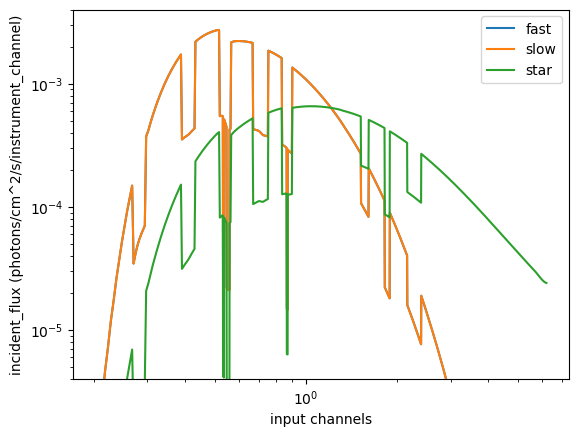

In [8]:
# incident fluxes

F_disk_slow = ST.background.get_F_disk(ST.instrument.energy_edges, ST.background.b_E, attenuate=True)
F_disk_fast = np.sum(ST.background.incident_background,axis=1) # background was divided with number of phases (phases in data) such that the total counts summed over phases is the correct total counts.
dF = 1/ST.signal.incident_flux_attenuated.shape[1]
F_star = np.sum(ST.signal.incident_flux_attenuated, axis=1)*dF# F_star is signal at each simulated phase point which are gsl_interp_eval_integ between data phase edges to get counts in each phase bin.



fig, ax = plt.subplots()

instrument_energy_mids = get_mids_from_edges(ST.instrument.energy_edges)

ax.loglog(instrument_energy_mids, F_disk_fast, label='fast')
ax.loglog(instrument_energy_mids, F_disk_slow, label='slow')
ax.loglog(instrument_energy_mids, F_star, label='star')

ax.set_ylabel('incident_flux (photons/cm^2/s/instrument_channel)')
ax.set_xlabel('input channels')
ax.set_ylim([4e-6, 4e-3])
ax.legend()

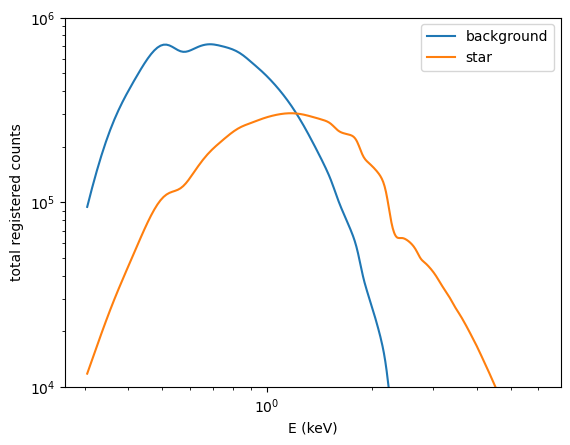

In [14]:
i_range = [ST.min_input, ST.max_input]
o_range = [ST.channel_low, ST.channel_hi]

registered_background=ST.signal.instrument(F_disk_fast, i_range, o_range)
registered_star=ST.signal.instrument(F_star, i_range, o_range)

fig, ax = plt.subplots()

ax.loglog(channel_mids, registered_background*ST.data.exposure_time,label='background')
ax.loglog(channel_mids, registered_star*ST.data.exposure_time,label='star')
ax.set_ylim([1e4,1e6])
ax.set_ylabel('total registered counts')
ax.set_xlabel('E (keV)')
ax.legend()